# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime
import time
from collections import deque
import matplotlib.pyplot as plt

In [2]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [3]:
import networkit as nk
import networkx as nx

# Setting

In [4]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "youtube")
    data_train = os.path.join(_data, "train")
    data_valid = os.path.join(_data, "valid")
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", date_time)
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 100
    
    nodes_cnt = 200

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [5]:
setting = Setting()

# Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

## Functions

### Load all data

In [6]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)
            
            # get filename without extension
            f = os.path.splitext(f)[0]
            p = os.path.join(path, "{}_score.txt".format(f))
            between.append(p)
    
    return edge_index, between

### Split Data

In [7]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)

### Cvt 2 Data

In [8]:
def to_data(x, y=None, x_sep=None, y_sep=None, usecols=None):
    
    if x_sep is not None:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long, sep=x_sep)
    else:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    if y is not None:
        ### between centrality
        bc = np.loadtxt(y, delimiter=y_sep, usecols=usecols)
        bc = np.reshape(bc, (-1, 1))
        bc = torch.from_numpy(bc)

        data = Data(x=vertice, edge_index=edge_index, y=bc)
        
    else:
        data = Data(x=vertice, edge_index=edge_index)
    
    return data

### Cvt 2 dataloader

In [9]:
def to_dataloader(x, y, batch, y_sep=None, usecols=None):
    
    data_list = []
    for x_, y_ in zip(x, y):
        data = to_data(x_, y_, y_sep=y_sep, usecols=usecols)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return loader

### Cvt nx.Graph 2 PyG.Data

In [10]:
def from_networkx(G, between_list=None):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    
    if between_list is not None:
        data['y'] = torch.from_numpy(
            np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

### Randomly generate nx.Graph

In [11]:
def generate_nx_graph(nodes_cnt):
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    return G, bc_gt

## Read data

### Load test data

In [12]:
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

In [13]:
train, train_bet = load_data(os.path.join(setting.data_train, str(setting.nodes_cnt)))

In [14]:
valid, valid_bet = load_data(os.path.join(setting.data_valid, str(setting.nodes_cnt)))

### Cvt to data/dataloader

In [15]:
train_loader = to_dataloader(train, train_bet, batch=8)
valid_loader = to_dataloader(valid, valid_bet, batch=8)

In [16]:
syn_loader = to_dataloader(synthetic, between, batch=1, usecols=1)

In [17]:
yt_loader = to_dataloader(yt, yt_score, batch=1, y_sep=":", usecols=1)

# Model

## Hyper params

In [18]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

setting.params_node2vec = dict(
    in_features = 128
)

## DrBC

In [19]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [20]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [21]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [22]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [23]:
import node2vec
from gensim.models import Word2Vec

INFO:gensim.summarization.textcleaner:'pattern' package not found; tag filters are not available for English


In [24]:
def learn_embeddings(walks, dim=128, window=10, workers=8, iters=1):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, size=dim, window=window, min_count=0, sg=1, workers=workers, iter=iters)
    
    return model.wv



def gnx_to_emb(G, nodes_cnt):
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1

    G = node2vec.Graph(G, False, p=1, q=1)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(10, 80)

    embs = learn_embeddings(walks)
    embs_ = []
    for index in range(nodes_cnt):
        embs_.append(torch.from_numpy(np.array(embs.get_vector(str(index)), dtype=np.float)))
    embs_ = torch.stack(embs_)
    
    
    return embs_

In [25]:
class BC_node2vec(nn.Module):
    
    def __init__(self, in_features):
        super().__init__()

        self.mlp = nn.Linear(in_features=in_features, out_features=1).double()
        
    def forward(self, emb):
        
        return self.mlp(emb)

# Evaluation

## Top k %

In [26]:
def top_n_percentage(bc_gt, bc_pr, k):
    
    if not isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.from_numpy(bc_gt)
    bc_gt = bc_gt.to(setting.device)
    bc_gt = torch.reshape(bc_gt, (-1, ))
    
    if not isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.from_numpy(bc_pr)
    bc_pr = bc_pr.to(setting.device)
    bc_pr = torch.reshape(bc_pr, (-1, ))
    
    nodes = bc_gt.size()[0]
    k = int(nodes * k / 100)
    
    gt_value, gt_indice = torch.topk(bc_gt, k)
    pr_value, pr_indice = torch.topk(bc_pr, k)

    gt_indice = set(gt_indice.cpu().numpy())
    pr_indice = set(pr_indice.cpu().numpy())

    intersect = len(gt_indice & pr_indice)
    top = intersect/k
    
    return top

## Tau Kendal

In [27]:
from scipy import stats

def kendal_tau_distance(bc_gt, bc_pr):
    
    if isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.reshape(bc_gt, (-1, ))
        bc_gt = bc_gt.cpu().detach().numpy()
        
    if isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.reshape(bc_pr, (-1, ))
        bc_pr = bc_pr.cpu().detach().numpy()
    
    tau, p_value = stats.kendalltau(bc_gt, bc_pr)
    return tau

# Train

## Load model

In [28]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

In [30]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

model

use a new optimizer


DrBC(
  (encoder): Encoder(
    (w_0): Linear(in_features=3, out_features=128, bias=True)
    (relu): ReLU(inplace=True)
    (rnn): GRUCell(128, 128)
  )
  (decoder): Decoder(
    (w_4): Linear(in_features=128, out_features=64, bias=True)
    (w_5): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU(inplace=True)
  )
)

## DrBC

In [31]:
nodes_cnt = setting.nodes_cnt


model.train()

train_info = {
    "mse": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "mse": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
#     G, bc_gt = generate_nx_graph(nodes_cnt)
    
#     # Convert networkx.Graph to Pyg Data
#     G = from_networkx(G)

    print("\nEpoch: {}".format(epoch+1))

    for batch in tqdm(train_loader):
    
        ### Start training
        optimizer.zero_grad()
        batch = batch.to(setting.device)

        bc_pr = model(batch)
    
        
        # compute batch loss
        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1
        
        batch_loss = torch.tensor(0, dtype=torch.float).to(setting.device)
        
        for b_ in range(b):
            
            indice, = np.where(b_index == b_)
            
            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()
            
            # random sample 5|V| nodes
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            
            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]
            
#             y_gt = nn.Sigmoid()(y_gt)
#             y_pr = nn.Sigmoid()(y_pr)
        
            batch_loss += nn.MSELoss()(y_pr, y_gt)
        
        batch_loss = torch.div(batch_loss, b)
        batch_loss.backward()
        optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
        
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(train_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)
                

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

#                 y_gt = nn.Sigmoid()(y_gt)
#                 y_pr = nn.Sigmoid()(y_pr)

                loss = nn.MSELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["mse"].append(bce)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)
            
            
    
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(valid_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)
            

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

#                 y_gt = nn.Sigmoid()(y_gt)
#                 y_pr = nn.Sigmoid()(y_pr)

                loss = nn.MSELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        valid_info["mse"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)



        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            top_10 = top10
            
            torch.save(checkpoint, setting.weight_drbc)

  0%|          | 0/1250 [00:00<?, ?it/s]


Epoch: 1


  8%|▊         | 1/13 [00:00<00:01,  9.22it/s]

Train: loss = 2.780760465889979e-06, top 1 = 0.95275, top 5 = 0.964239999999941, top 10 = 0.9623699999999815, kendal = 0.8652761852980011


  0%|          | 1/1250 [00:00<03:31,  5.92it/s]

Valid: loss = 2.6854486443188385e-06, top 1 = 0.95, top 5 = 0.9560000000000002, top 10 = 0.9610000000000011, kendal = 0.863317216148458

Epoch: 2


  8%|▊         | 1/13 [00:00<00:01,  6.88it/s]

Train: loss = 1.9442269432582785e-06, top 1 = 0.96425, top 5 = 0.9703999999999503, top 10 = 0.9661749999999852, kendal = 0.8773400173250139


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 2.0845377190195002e-06, top 1 = 0.945, top 5 = 0.9620000000000002, top 10 = 0.9635000000000011, kendal = 0.8768609548426827

Epoch: 3


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 2.025889702602961e-06, top 1 = 0.9653, top 5 = 0.9719999999999516, top 10 = 0.9677349999999875, kendal = 0.8821143123879883


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 2.1993899677161356e-06, top 1 = 0.95, top 5 = 0.9660000000000002, top 10 = 0.966500000000001, kendal = 0.8814840716074558

Epoch: 4


 15%|█▌        | 2/13 [00:00<00:00, 13.27it/s]

Train: loss = 1.762209546478253e-06, top 1 = 0.96695, top 5 = 0.9736799999999545, top 10 = 0.9689749999999901, kendal = 0.8875023528321749


  0%|          | 1/1250 [00:00<03:25,  6.09it/s]

Valid: loss = 1.954097923102992e-06, top 1 = 0.945, top 5 = 0.9670000000000002, top 10 = 0.968500000000001, kendal = 0.8870277881296883

Epoch: 5


  8%|▊         | 1/13 [00:00<00:02,  5.04it/s]

Train: loss = 1.652692536095984e-06, top 1 = 0.9681, top 5 = 0.9743299999999555, top 10 = 0.9695849999999924, kendal = 0.8891976583828631


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.8339670580446997e-06, top 1 = 0.945, top 5 = 0.9690000000000002, top 10 = 0.966500000000001, kendal = 0.888439845375602

Epoch: 6


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.5538284547714583e-06, top 1 = 0.9686, top 5 = 0.9749299999999562, top 10 = 0.9702049999999939, kendal = 0.8912056217302139


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.8143199150097789e-06, top 1 = 0.94, top 5 = 0.9720000000000003, top 10 = 0.9690000000000011, kendal = 0.8906036640922873

Epoch: 7


  8%|▊         | 1/13 [00:00<00:01,  9.09it/s]

Train: loss = 1.5752130973122652e-06, top 1 = 0.96935, top 5 = 0.9752399999999567, top 10 = 0.9705849999999933, kendal = 0.893454586683633


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.8621944882565034e-06, top 1 = 0.94, top 5 = 0.9720000000000003, top 10 = 0.969500000000001, kendal = 0.8921785379338367

Epoch: 8


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.461816846693803e-06, top 1 = 0.96955, top 5 = 0.9751599999999562, top 10 = 0.970924999999993, kendal = 0.8934771595671466


  0%|          | 1/1250 [00:00<03:13,  6.45it/s]

Valid: loss = 1.692597699482453e-06, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.970000000000001, kendal = 0.8918951208231569

Epoch: 9


  8%|▊         | 1/13 [00:00<00:01,  6.93it/s]

Train: loss = 1.66368351767881e-06, top 1 = 0.9696, top 5 = 0.975479999999957, top 10 = 0.9710649999999945, kendal = 0.8944115045843973


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 2.004015169058197e-06, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.968000000000001, kendal = 0.8927624579611245

Epoch: 10


  8%|▊         | 1/13 [00:00<00:01,  8.26it/s]

Train: loss = 1.3000288373871476e-06, top 1 = 0.97025, top 5 = 0.9755999999999568, top 10 = 0.9713699999999944, kendal = 0.8962187554063828


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5538676427604952e-06, top 1 = 0.945, top 5 = 0.9760000000000002, top 10 = 0.9705000000000009, kendal = 0.8950016562642863

Epoch: 11


  8%|▊         | 1/13 [00:00<00:01,  8.27it/s]

Train: loss = 1.4102735818112876e-06, top 1 = 0.9696, top 5 = 0.9761799999999579, top 10 = 0.9715149999999952, kendal = 0.8967447946675804


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.6741765366384896e-06, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.9705000000000009, kendal = 0.8956448724962047

Epoch: 12


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.2961709636569765e-06, top 1 = 0.9701, top 5 = 0.9761299999999579, top 10 = 0.9716249999999939, kendal = 0.8963910492005027


  0%|          | 1/1250 [00:00<02:05,  9.92it/s]

Valid: loss = 1.5847477750464661e-06, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.9690000000000011, kendal = 0.8948368315628672

Epoch: 13


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.3312185535434997e-06, top 1 = 0.9705, top 5 = 0.976199999999958, top 10 = 0.9718349999999939, kendal = 0.8974679660973143


  0%|          | 1/1250 [00:00<03:48,  5.47it/s]

Valid: loss = 1.6626274777292276e-06, top 1 = 0.945, top 5 = 0.9780000000000002, top 10 = 0.970000000000001, kendal = 0.8962328113866062

Epoch: 14


  8%|▊         | 1/13 [00:00<00:01,  6.00it/s]

Train: loss = 1.2926845269611862e-06, top 1 = 0.9707, top 5 = 0.976199999999958, top 10 = 0.9719999999999942, kendal = 0.8965012199888591


  0%|          | 1/1250 [00:00<02:16,  9.16it/s]

Valid: loss = 1.6408048237779354e-06, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.969500000000001, kendal = 0.8953353245554885

Epoch: 15


  8%|▊         | 1/13 [00:00<00:01,  7.40it/s]

Train: loss = 1.361739042962978e-06, top 1 = 0.97025, top 5 = 0.9765199999999588, top 10 = 0.9720749999999947, kendal = 0.8975566070750507


  0%|          | 1/1250 [00:00<03:14,  6.41it/s]

Valid: loss = 1.6870506969231139e-06, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.970000000000001, kendal = 0.8966107014651632

Epoch: 16


  8%|▊         | 1/13 [00:00<00:01,  9.93it/s]

Train: loss = 1.2504286308256837e-06, top 1 = 0.97125, top 5 = 0.9765199999999584, top 10 = 0.9722349999999951, kendal = 0.8974346048175139


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5802546878116128e-06, top 1 = 0.945, top 5 = 0.9760000000000002, top 10 = 0.9710000000000011, kendal = 0.8962378361839471

Epoch: 17


  8%|▊         | 1/13 [00:00<00:01,  6.68it/s]

Train: loss = 1.196932044232393e-06, top 1 = 0.97135, top 5 = 0.9766399999999587, top 10 = 0.9723599999999946, kendal = 0.8978559994840442


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5037454562751816e-06, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.972500000000001, kendal = 0.8966911040055237

Epoch: 18


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.2017863470805276e-06, top 1 = 0.9712, top 5 = 0.9767699999999587, top 10 = 0.9724899999999945, kendal = 0.898674425257993


  0%|          | 1/1250 [00:00<02:50,  7.34it/s]

Valid: loss = 1.5023768419992697e-06, top 1 = 0.945, top 5 = 0.9760000000000002, top 10 = 0.9710000000000011, kendal = 0.8975936164168203

Epoch: 19


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.1433898269195443e-06, top 1 = 0.97145, top 5 = 0.9767399999999586, top 10 = 0.9725349999999963, kendal = 0.8980400688639278


  0%|          | 2/1250 [00:00<01:32, 13.46it/s]

Valid: loss = 1.4669110711330188e-06, top 1 = 0.945, top 5 = 0.9760000000000002, top 10 = 0.9710000000000011, kendal = 0.8969825600798191

Epoch: 20


  8%|▊         | 1/13 [00:00<00:01,  7.34it/s]

Train: loss = 1.1989632612061684e-06, top 1 = 0.97105, top 5 = 0.9769199999999595, top 10 = 0.9725599999999955, kendal = 0.8983268304689204


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5548239814691033e-06, top 1 = 0.945, top 5 = 0.9760000000000002, top 10 = 0.971000000000001, kendal = 0.897152409932118

Epoch: 21


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.1563219480700656e-06, top 1 = 0.97155, top 5 = 0.9769399999999591, top 10 = 0.9727149999999952, kendal = 0.8970465411881084


  0%|          | 2/1250 [00:00<01:31, 13.58it/s]

Valid: loss = 1.5691019523146887e-06, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.971500000000001, kendal = 0.8957594440978843

Epoch: 22


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.2842241271131495e-06, top 1 = 0.97125, top 5 = 0.9770799999999598, top 10 = 0.9727799999999959, kendal = 0.8988296949003849


  0%|          | 1/1250 [00:00<02:13,  9.38it/s]

Valid: loss = 1.6782103328383137e-06, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.9705000000000009, kendal = 0.8976880872634593

Epoch: 23


  8%|▊         | 1/13 [00:00<00:01,  6.53it/s]

Train: loss = 1.1788335023069391e-06, top 1 = 0.9718, top 5 = 0.9771199999999594, top 10 = 0.9729149999999954, kendal = 0.8985937729630361


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5702423522188116e-06, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.970000000000001, kendal = 0.8972699961041186

Epoch: 24


  8%|▊         | 1/13 [00:00<00:01,  7.34it/s]

Train: loss = 1.2681726592401641e-06, top 1 = 0.9721, top 5 = 0.9772399999999596, top 10 = 0.9728599999999955, kendal = 0.8988403837751233


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.6308470237521648e-06, top 1 = 0.945, top 5 = 0.9740000000000003, top 10 = 0.9705000000000009, kendal = 0.8977604482896662

Epoch: 25


  8%|▊         | 1/13 [00:00<00:01,  8.40it/s]

Train: loss = 1.1962524859285347e-06, top 1 = 0.9719, top 5 = 0.9770599999999596, top 10 = 0.9731299999999946, kendal = 0.8993428036372286


  0%|          | 1/1250 [00:00<03:50,  5.41it/s]

Valid: loss = 1.5694166620424652e-06, top 1 = 0.95, top 5 = 0.9760000000000005, top 10 = 0.970000000000001, kendal = 0.8980006488401397

Epoch: 26


  8%|▊         | 1/13 [00:00<00:01,  7.88it/s]

Train: loss = 1.2178974171008546e-06, top 1 = 0.97185, top 5 = 0.9770499999999597, top 10 = 0.9730499999999949, kendal = 0.8986143513557209


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.6460024443970801e-06, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.969500000000001, kendal = 0.8976368308052818

Epoch: 27


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.165388426038598e-06, top 1 = 0.97245, top 5 = 0.97737999999996, top 10 = 0.9730199999999953, kendal = 0.899093609843145


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.551696197646458e-06, top 1 = 0.945, top 5 = 0.9720000000000004, top 10 = 0.9705000000000011, kendal = 0.8979142181692539

Epoch: 28


  8%|▊         | 1/13 [00:00<00:01,  6.17it/s]

Train: loss = 1.140179248109378e-06, top 1 = 0.9724, top 5 = 0.9773899999999596, top 10 = 0.9731399999999943, kendal = 0.8996880320430973


  0%|          | 1/1250 [00:00<02:06,  9.85it/s]

Valid: loss = 1.5396624440372156e-06, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.969500000000001, kendal = 0.8983051724633192

Epoch: 29


  8%|▊         | 1/13 [00:00<00:02,  5.71it/s]

Train: loss = 1.2621135634126619e-06, top 1 = 0.97205, top 5 = 0.97714999999996, top 10 = 0.9731549999999949, kendal = 0.8998559282965211


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.6589004685485082e-06, top 1 = 0.95, top 5 = 0.9750000000000003, top 10 = 0.969500000000001, kendal = 0.8986438670165274

Epoch: 30


 15%|█▌        | 2/13 [00:00<00:00, 15.39it/s]

Train: loss = 1.0660230690270013e-06, top 1 = 0.97305, top 5 = 0.9774099999999598, top 10 = 0.9734399999999952, kendal = 0.8997376980338341


  0%|          | 2/1250 [00:00<01:58, 10.52it/s]

Valid: loss = 1.4091063851673572e-06, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.9705000000000009, kendal = 0.8983503998061083

Epoch: 31


  8%|▊         | 1/13 [00:00<00:02,  5.15it/s]

Train: loss = 1.2090003591517622e-06, top 1 = 0.97295, top 5 = 0.9774899999999599, top 10 = 0.9733549999999946, kendal = 0.9003069142165121


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.6201057937160983e-06, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.971000000000001, kendal = 0.8988247716906579

Epoch: 32


  8%|▊         | 1/13 [00:00<00:01,  9.83it/s]

Train: loss = 1.2045324971981846e-06, top 1 = 0.9725, top 5 = 0.9776399999999603, top 10 = 0.973299999999996, kendal = 0.8991505669028391


  0%|          | 1/1250 [00:00<03:42,  5.60it/s]

Valid: loss = 1.6371719934952387e-06, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.971500000000001, kendal = 0.8978740181743425

Epoch: 33


  8%|▊         | 1/13 [00:00<00:01,  8.42it/s]

Train: loss = 1.2031209946255416e-06, top 1 = 0.97255, top 5 = 0.9776999999999604, top 10 = 0.9733499999999949, kendal = 0.9003528181831089


  0%|          | 1/1250 [00:00<02:47,  7.48it/s]

Valid: loss = 1.5591556765135486e-06, top 1 = 0.945, top 5 = 0.9780000000000004, top 10 = 0.9710000000000011, kendal = 0.8989514048059817

Epoch: 34


  8%|▊         | 1/13 [00:00<00:02,  5.75it/s]

Train: loss = 1.1947789755892442e-06, top 1 = 0.97275, top 5 = 0.9777899999999603, top 10 = 0.9732549999999955, kendal = 0.9007678836461058


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5990999168230045e-06, top 1 = 0.945, top 5 = 0.9770000000000003, top 10 = 0.9710000000000011, kendal = 0.8992137168688272

Epoch: 35


  8%|▊         | 1/13 [00:00<00:01,  7.66it/s]

Train: loss = 1.1308139162364807e-06, top 1 = 0.97285, top 5 = 0.9778499999999604, top 10 = 0.9735299999999958, kendal = 0.9013675698168924


  0%|          | 1/1250 [00:00<03:09,  6.58it/s]

Valid: loss = 1.5044097294477223e-06, top 1 = 0.945, top 5 = 0.9760000000000004, top 10 = 0.972000000000001, kendal = 0.8999232646832789

Epoch: 36


 15%|█▌        | 2/13 [00:00<00:00, 17.09it/s]

Train: loss = 1.2915934236945732e-06, top 1 = 0.9729, top 5 = 0.9781099999999605, top 10 = 0.9735399999999956, kendal = 0.900512755632396


  0%|          | 1/1250 [00:00<02:58,  7.00it/s]

Valid: loss = 1.664738894210498e-06, top 1 = 0.945, top 5 = 0.9770000000000003, top 10 = 0.971500000000001, kendal = 0.8989112037757038

Epoch: 37


  8%|▊         | 1/13 [00:00<00:01,  8.43it/s]

Train: loss = 1.0890852247043988e-06, top 1 = 0.97295, top 5 = 0.9777799999999607, top 10 = 0.9735399999999954, kendal = 0.9012359640511444


  0%|          | 1/1250 [00:00<02:39,  7.83it/s]

Valid: loss = 1.3775333358942062e-06, top 1 = 0.95, top 5 = 0.9770000000000003, top 10 = 0.9715000000000009, kendal = 0.899346379857123

Epoch: 38


  8%|▊         | 1/13 [00:00<00:01,  8.57it/s]

Train: loss = 1.119287482462407e-06, top 1 = 0.9727, top 5 = 0.9777599999999602, top 10 = 0.9736949999999958, kendal = 0.9007989109373485


  0%|          | 1/1250 [00:00<02:18,  9.01it/s]

Valid: loss = 1.463103003122152e-06, top 1 = 0.95, top 5 = 0.9760000000000004, top 10 = 0.9730000000000011, kendal = 0.8993594480120742

Epoch: 39


  8%|▊         | 1/13 [00:00<00:01,  6.19it/s]

Train: loss = 1.0491118909721983e-06, top 1 = 0.97325, top 5 = 0.9779299999999604, top 10 = 0.9736799999999963, kendal = 0.8994175161942989


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.3697157995594443e-06, top 1 = 0.945, top 5 = 0.9760000000000002, top 10 = 0.9725000000000008, kendal = 0.8980217583324744

Epoch: 40


  8%|▊         | 1/13 [00:00<00:02,  5.90it/s]

Train: loss = 1.1790456789272584e-06, top 1 = 0.97365, top 5 = 0.9778899999999602, top 10 = 0.9736849999999962, kendal = 0.9016161729173197


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5588546132527854e-06, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.9720000000000009, kendal = 0.900300150166009

Epoch: 41


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.0949024274157936e-06, top 1 = 0.9728, top 5 = 0.9781199999999611, top 10 = 0.9736949999999962, kendal = 0.9007203782704956


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5156395194482526e-06, top 1 = 0.955, top 5 = 0.9770000000000003, top 10 = 0.9725000000000011, kendal = 0.8993262806425056

Epoch: 42


 15%|█▌        | 2/13 [00:00<00:00, 12.06it/s]

Train: loss = 1.067440191328276e-06, top 1 = 0.9736, top 5 = 0.978239999999961, top 10 = 0.9738949999999957, kendal = 0.9024788430368124


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.4360251265689122e-06, top 1 = 0.945, top 5 = 0.9750000000000003, top 10 = 0.9725000000000008, kendal = 0.9008689930992196

Epoch: 43


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.0291278314158077e-06, top 1 = 0.97305, top 5 = 0.9780599999999607, top 10 = 0.9738999999999963, kendal = 0.9026140668866945


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.3709317118177133e-06, top 1 = 0.95, top 5 = 0.9770000000000002, top 10 = 0.973000000000001, kendal = 0.9009041687260884

Epoch: 44


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.1561690949475084e-06, top 1 = 0.97375, top 5 = 0.9783899999999613, top 10 = 0.9738499999999966, kendal = 0.9025972583479919


  0%|          | 1/1250 [00:00<03:01,  6.87it/s]

Valid: loss = 1.517005603200462e-06, top 1 = 0.95, top 5 = 0.9770000000000002, top 10 = 0.9725000000000008, kendal = 0.9009051743067765

Epoch: 45


 15%|█▌        | 2/13 [00:00<00:00, 11.22it/s]

Train: loss = 1.1186861443241185e-06, top 1 = 0.97335, top 5 = 0.9784799999999619, top 10 = 0.974094999999996, kendal = 0.9029652483449663


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.4662964341669324e-06, top 1 = 0.95, top 5 = 0.9780000000000002, top 10 = 0.9735000000000009, kendal = 0.9011845705593688

Epoch: 46


 15%|█▌        | 2/13 [00:00<00:01, 10.39it/s]

Train: loss = 1.0259828617837943e-06, top 1 = 0.9739, top 5 = 0.9783699999999619, top 10 = 0.9738449999999961, kendal = 0.9017894191358544


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.3439487169293106e-06, top 1 = 0.95, top 5 = 0.9770000000000003, top 10 = 0.973000000000001, kendal = 0.9001614556633061

Epoch: 47


  8%|▊         | 1/13 [00:00<00:01,  9.93it/s]

Train: loss = 1.1675915724752596e-06, top 1 = 0.97365, top 5 = 0.9785499999999618, top 10 = 0.9741249999999961, kendal = 0.9008399562897408


  0%|          | 1/1250 [00:00<02:40,  7.79it/s]

Valid: loss = 1.6047803327674164e-06, top 1 = 0.95, top 5 = 0.9770000000000003, top 10 = 0.973000000000001, kendal = 0.898861955499068

Epoch: 48


 23%|██▎       | 3/13 [00:00<00:00, 19.60it/s]

Train: loss = 1.1348218400737113e-06, top 1 = 0.9739, top 5 = 0.978499999999962, top 10 = 0.9742699999999959, kendal = 0.9033984589182182


  0%|          | 1/1250 [00:00<02:37,  7.94it/s]

Valid: loss = 1.53093001776384e-06, top 1 = 0.95, top 5 = 0.9770000000000002, top 10 = 0.9750000000000009, kendal = 0.9019061772864221

Epoch: 49


 15%|█▌        | 2/13 [00:00<00:00, 12.63it/s]

Train: loss = 1.030469705384311e-06, top 1 = 0.9741, top 5 = 0.9784899999999618, top 10 = 0.9741699999999959, kendal = 0.9019658311519639


  0%|          | 1/1250 [00:00<03:09,  6.59it/s]

Valid: loss = 1.4039518412225424e-06, top 1 = 0.945, top 5 = 0.9780000000000002, top 10 = 0.9745000000000009, kendal = 0.9001282877129216

Epoch: 50


  8%|▊         | 1/13 [00:00<00:01,  6.97it/s]

Train: loss = 1.2020473279370564e-06, top 1 = 0.9748, top 5 = 0.9787899999999623, top 10 = 0.974184999999997, kendal = 0.8997983313067376


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.6124024018473202e-06, top 1 = 0.95, top 5 = 0.9770000000000002, top 10 = 0.9745000000000009, kendal = 0.8978649689582626

Epoch: 51


 15%|█▌        | 2/13 [00:00<00:00, 15.49it/s]

Train: loss = 1.0242004543791748e-06, top 1 = 0.9746, top 5 = 0.9786599999999622, top 10 = 0.9742049999999978, kendal = 0.9019858055465837


  0%|          | 2/1250 [00:00<01:45, 11.83it/s]

Valid: loss = 1.4086767697766247e-06, top 1 = 0.945, top 5 = 0.9760000000000002, top 10 = 0.974500000000001, kendal = 0.899990596846438

Epoch: 52


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.055272021771568e-06, top 1 = 0.9745, top 5 = 0.9789199999999628, top 10 = 0.9743849999999961, kendal = 0.9024664990485124


  0%|          | 2/1250 [00:00<01:48, 11.54it/s]

Valid: loss = 1.3982057656849844e-06, top 1 = 0.945, top 5 = 0.9790000000000003, top 10 = 0.975000000000001, kendal = 0.9004850696122927

Epoch: 53


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 9.956804183631541e-07, top 1 = 0.97455, top 5 = 0.9789199999999628, top 10 = 0.9745049999999971, kendal = 0.9037738591275031


  0%|          | 2/1250 [00:00<01:46, 11.76it/s]

Valid: loss = 1.4116954800760456e-06, top 1 = 0.95, top 5 = 0.9770000000000002, top 10 = 0.973000000000001, kendal = 0.9018589384034638

Epoch: 54


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.2070405917256328e-06, top 1 = 0.97365, top 5 = 0.9787399999999626, top 10 = 0.9746599999999964, kendal = 0.9047318861622343


  0%|          | 1/1250 [00:00<02:23,  8.69it/s]

Valid: loss = 1.623144958690867e-06, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9745000000000009, kendal = 0.9027745132878227

Epoch: 55


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.0676874341240659e-06, top 1 = 0.9743, top 5 = 0.9788199999999629, top 10 = 0.9747199999999968, kendal = 0.9031303313754232


  0%|          | 1/1250 [00:00<02:33,  8.13it/s]

Valid: loss = 1.497901377976142e-06, top 1 = 0.945, top 5 = 0.9780000000000004, top 10 = 0.9750000000000009, kendal = 0.9007242623345756

Epoch: 56


 15%|█▌        | 2/13 [00:00<00:00, 13.03it/s]

Train: loss = 1.1332767662682249e-06, top 1 = 0.97405, top 5 = 0.9788899999999626, top 10 = 0.9747449999999978, kendal = 0.9025592628118005


  0%|          | 1/1250 [00:00<03:13,  6.47it/s]

Valid: loss = 1.6045616689424882e-06, top 1 = 0.95, top 5 = 0.9780000000000002, top 10 = 0.975000000000001, kendal = 0.9005162206689059

Epoch: 57


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 9.973223604528892e-07, top 1 = 0.97415, top 5 = 0.9791199999999634, top 10 = 0.9748499999999972, kendal = 0.9017946520603245


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.4723303919515442e-06, top 1 = 0.95, top 5 = 0.9790000000000003, top 10 = 0.9740000000000008, kendal = 0.899604663688052

Epoch: 58


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.1398300670801191e-06, top 1 = 0.9745, top 5 = 0.9792399999999628, top 10 = 0.9746799999999975, kendal = 0.9022023683275614


  0%|          | 2/1250 [00:00<01:33, 13.33it/s]

Valid: loss = 1.625261008429205e-06, top 1 = 0.95, top 5 = 0.9760000000000002, top 10 = 0.9760000000000008, kendal = 0.8999343106918687

Epoch: 59


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.0058702015582224e-06, top 1 = 0.97465, top 5 = 0.9791899999999634, top 10 = 0.975044999999998, kendal = 0.9034239061796583


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5003778369104788e-06, top 1 = 0.95, top 5 = 0.9760000000000002, top 10 = 0.9765000000000009, kendal = 0.9011172259718127

Epoch: 60


 15%|█▌        | 2/13 [00:00<00:00, 16.60it/s]

Train: loss = 1.1635393091935825e-06, top 1 = 0.9749, top 5 = 0.9791899999999639, top 10 = 0.975059999999998, kendal = 0.9016501673104241


  0%|          | 2/1250 [00:00<01:04, 19.36it/s]

Valid: loss = 1.6293789922885115e-06, top 1 = 0.95, top 5 = 0.9770000000000002, top 10 = 0.976000000000001, kendal = 0.8994448645163073

Epoch: 61


  8%|▊         | 1/13 [00:00<00:02,  5.37it/s]

Train: loss = 1.089584637253557e-06, top 1 = 0.9746, top 5 = 0.9792199999999631, top 10 = 0.9751099999999975, kendal = 0.904705954174638


  0%|          | 2/1250 [00:00<01:33, 13.30it/s]

Valid: loss = 1.5818943181618932e-06, top 1 = 0.95, top 5 = 0.9760000000000002, top 10 = 0.9745000000000009, kendal = 0.902455917848221

Epoch: 62


 15%|█▌        | 2/13 [00:00<00:00, 16.72it/s]

Train: loss = 1.1590956419299215e-06, top 1 = 0.975, top 5 = 0.9790999999999634, top 10 = 0.975154999999997, kendal = 0.9014320064483223


  0%|          | 2/1250 [00:00<01:31, 13.61it/s]

Valid: loss = 1.7476207145760116e-06, top 1 = 0.95, top 5 = 0.9780000000000002, top 10 = 0.9755000000000008, kendal = 0.8992518984547974

Epoch: 63


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.0570215301500449e-06, top 1 = 0.9749, top 5 = 0.9792899999999636, top 10 = 0.9752449999999977, kendal = 0.9020079808803138


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.556803605285372e-06, top 1 = 0.95, top 5 = 0.9770000000000003, top 10 = 0.9755000000000008, kendal = 0.899619739115442

Epoch: 64


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.342656028458413e-06, top 1 = 0.975, top 5 = 0.9791799999999635, top 10 = 0.9753599999999973, kendal = 0.9041603126979524


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.8697605506193523e-06, top 1 = 0.95, top 5 = 0.9790000000000002, top 10 = 0.9755000000000008, kendal = 0.9017996381331259

Epoch: 65


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.0116880778170298e-06, top 1 = 0.97525, top 5 = 0.9793299999999634, top 10 = 0.975269999999997, kendal = 0.9014524039420386


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5205177505676477e-06, top 1 = 0.95, top 5 = 0.9790000000000002, top 10 = 0.9765000000000008, kendal = 0.8990287829779199

Epoch: 66


  8%|▊         | 1/13 [00:00<00:02,  5.94it/s]

Train: loss = 1.1331663949214428e-06, top 1 = 0.9751, top 5 = 0.9793199999999637, top 10 = 0.9752599999999969, kendal = 0.9019617730377877


  0%|          | 1/1250 [00:00<04:04,  5.11it/s]

Valid: loss = 1.6826334725937467e-06, top 1 = 0.95, top 5 = 0.9780000000000002, top 10 = 0.9760000000000008, kendal = 0.8996860697636195

Epoch: 67


  8%|▊         | 1/13 [00:00<00:02,  5.71it/s]

Train: loss = 9.969731360968914e-07, top 1 = 0.97555, top 5 = 0.9794399999999636, top 10 = 0.9755249999999973, kendal = 0.9030334716762137


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.430525276431758e-06, top 1 = 0.955, top 5 = 0.9770000000000002, top 10 = 0.9765000000000006, kendal = 0.9004056671475018

Epoch: 68


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.1227947836737814e-06, top 1 = 0.97445, top 5 = 0.9793399999999639, top 10 = 0.9754599999999973, kendal = 0.9039579107050748


  0%|          | 2/1250 [00:00<01:41, 12.35it/s]

Valid: loss = 1.6287728592120584e-06, top 1 = 0.96, top 5 = 0.9790000000000003, top 10 = 0.9760000000000008, kendal = 0.9016006419461152

Epoch: 69


  8%|▊         | 1/13 [00:00<00:01,  8.43it/s]

Train: loss = 1.0256408366056058e-06, top 1 = 0.97535, top 5 = 0.9796699999999643, top 10 = 0.9756949999999978, kendal = 0.9042056448372597


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5917971103235186e-06, top 1 = 0.955, top 5 = 0.9790000000000002, top 10 = 0.9760000000000008, kendal = 0.9019735070505618

Epoch: 70


 15%|█▌        | 2/13 [00:00<00:00, 14.58it/s]

Train: loss = 1.0375530771324757e-06, top 1 = 0.9756, top 5 = 0.979529999999964, top 10 = 0.9757299999999981, kendal = 0.9066381396947347


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5750944805426168e-06, top 1 = 0.955, top 5 = 0.9780000000000001, top 10 = 0.9750000000000009, kendal = 0.9043383309691415

Epoch: 71


  8%|▊         | 1/13 [00:00<00:01,  6.23it/s]

Train: loss = 1.0294710054853793e-06, top 1 = 0.9763, top 5 = 0.9797099999999646, top 10 = 0.975599999999998, kendal = 0.9054596873526132


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5110863498166456e-06, top 1 = 0.955, top 5 = 0.9790000000000002, top 10 = 0.9775000000000007, kendal = 0.9031845624027015

Epoch: 72


  8%|▊         | 1/13 [00:00<00:01,  7.74it/s]

Train: loss = 9.30525945610775e-07, top 1 = 0.97475, top 5 = 0.979499999999964, top 10 = 0.9758599999999982, kendal = 0.9062025996659268


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.4143218278131949e-06, top 1 = 0.955, top 5 = 0.9760000000000002, top 10 = 0.9755000000000008, kendal = 0.904054915424137

Epoch: 73


 15%|█▌        | 2/13 [00:00<00:00, 12.39it/s]

Train: loss = 1.0222803927056087e-06, top 1 = 0.97565, top 5 = 0.9796199999999642, top 10 = 0.9756799999999987, kendal = 0.9046359919968898


  0%|          | 1/1250 [00:00<03:08,  6.62it/s]

Valid: loss = 1.512216550674181e-06, top 1 = 0.955, top 5 = 0.9760000000000002, top 10 = 0.9760000000000008, kendal = 0.9025323012729386

Epoch: 74


  8%|▊         | 1/13 [00:00<00:01,  6.09it/s]

Train: loss = 1.20901016707642e-06, top 1 = 0.97545, top 5 = 0.9797599999999642, top 10 = 0.975874999999998, kendal = 0.9065811023226849


  0%|          | 1/1250 [00:00<02:14,  9.26it/s]

Valid: loss = 1.8435547357091538e-06, top 1 = 0.955, top 5 = 0.9800000000000001, top 10 = 0.9765000000000008, kendal = 0.9043765214946172

Epoch: 75


  8%|▊         | 1/13 [00:00<00:01,  8.22it/s]

Train: loss = 1.0545378288224766e-06, top 1 = 0.976, top 5 = 0.9797299999999641, top 10 = 0.9758149999999987, kendal = 0.9045384689778182


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5024711863082142e-06, top 1 = 0.955, top 5 = 0.9800000000000001, top 10 = 0.9755000000000008, kendal = 0.9022850647384941

Epoch: 76


 15%|█▌        | 2/13 [00:00<00:00, 13.33it/s]

Train: loss = 9.74798861033467e-07, top 1 = 0.97575, top 5 = 0.9797299999999637, top 10 = 0.9757999999999983, kendal = 0.9026863481538309


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5033963172443184e-06, top 1 = 0.955, top 5 = 0.9760000000000002, top 10 = 0.9765000000000008, kendal = 0.9004498884803047

Epoch: 77


  8%|▊         | 1/13 [00:00<00:01,  6.78it/s]

Train: loss = 1.0231233642500173e-06, top 1 = 0.9755, top 5 = 0.9795599999999632, top 10 = 0.9757949999999981, kendal = 0.9064027504505066


  0%|          | 2/1250 [00:00<01:08, 18.28it/s]

Valid: loss = 1.5461936381561591e-06, top 1 = 0.95, top 5 = 0.9780000000000001, top 10 = 0.9765000000000008, kendal = 0.9043765197016653

Epoch: 78


 15%|█▌        | 2/13 [00:00<00:00, 19.82it/s]

Train: loss = 9.6565780716323e-07, top 1 = 0.9755, top 5 = 0.9795599999999632, top 10 = 0.9760649999999983, kendal = 0.9049306174460151


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.4837733414673268e-06, top 1 = 0.955, top 5 = 0.9760000000000002, top 10 = 0.9770000000000008, kendal = 0.9029041606956854

Epoch: 79


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.0444027690191e-06, top 1 = 0.97575, top 5 = 0.979799999999964, top 10 = 0.9761999999999987, kendal = 0.9082642760286426


  0%|          | 1/1250 [00:00<03:04,  6.76it/s]

Valid: loss = 1.619731386027881e-06, top 1 = 0.955, top 5 = 0.9780000000000001, top 10 = 0.9765000000000008, kendal = 0.9058941070858016

Epoch: 80


 15%|█▌        | 2/13 [00:00<00:00, 16.40it/s]

Train: loss = 1.169504527408761e-06, top 1 = 0.97535, top 5 = 0.9799499999999646, top 10 = 0.9761799999999982, kendal = 0.9074219488184968


  0%|          | 1/1250 [00:00<04:07,  5.04it/s]

Valid: loss = 1.7574236067322572e-06, top 1 = 0.955, top 5 = 0.9770000000000002, top 10 = 0.9740000000000008, kendal = 0.9051855677056082

Epoch: 81


 15%|█▌        | 2/13 [00:00<00:00, 19.08it/s]

Train: loss = 9.793576891013452e-07, top 1 = 0.97555, top 5 = 0.9797299999999636, top 10 = 0.9762149999999982, kendal = 0.907296514799863


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.4410837187384942e-06, top 1 = 0.955, top 5 = 0.9780000000000001, top 10 = 0.9765000000000008, kendal = 0.9051212452389713

Epoch: 82


  8%|▊         | 1/13 [00:00<00:01,  7.21it/s]

Train: loss = 9.54094412902983e-07, top 1 = 0.97545, top 5 = 0.979809999999964, top 10 = 0.9763949999999988, kendal = 0.9071766934049299


  0%|          | 2/1250 [00:00<01:33, 13.30it/s]

Valid: loss = 1.4061983856762818e-06, top 1 = 0.95, top 5 = 0.9770000000000002, top 10 = 0.9765000000000008, kendal = 0.9048016476025618

Epoch: 83


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 1.0479219094949172e-06, top 1 = 0.97525, top 5 = 0.9800799999999644, top 10 = 0.9763549999999981, kendal = 0.9050387681831175


  0%|          | 1/1250 [00:00<03:36,  5.78it/s]

Valid: loss = 1.5536850118884996e-06, top 1 = 0.95, top 5 = 0.9780000000000002, top 10 = 0.9755000000000008, kendal = 0.9028368240880263

Epoch: 84


 15%|█▌        | 2/13 [00:00<00:00, 12.80it/s]

Train: loss = 9.74480256892841e-07, top 1 = 0.97525, top 5 = 0.9797199999999633, top 10 = 0.9761299999999986, kendal = 0.9070578436466203


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.4907558878149064e-06, top 1 = 0.955, top 5 = 0.9770000000000002, top 10 = 0.9760000000000008, kendal = 0.9044760189062956

Epoch: 85


  8%|▊         | 1/13 [00:00<00:02,  5.36it/s]

Train: loss = 9.177583620600753e-07, top 1 = 0.9761, top 5 = 0.9801199999999646, top 10 = 0.9764699999999984, kendal = 0.9084222156753609


  0%|          | 2/1250 [00:00<01:32, 13.48it/s]

Valid: loss = 1.401180545839046e-06, top 1 = 0.955, top 5 = 0.9770000000000002, top 10 = 0.9770000000000008, kendal = 0.9060066702029058

Epoch: 86


  8%|▊         | 1/13 [00:00<00:01,  8.95it/s]

Train: loss = 1.018086110657224e-06, top 1 = 0.9755, top 5 = 0.9799599999999644, top 10 = 0.9765649999999998, kendal = 0.9085756628665947


  0%|          | 2/1250 [00:00<01:42, 12.19it/s]

Valid: loss = 1.5124397461527752e-06, top 1 = 0.96, top 5 = 0.9760000000000002, top 10 = 0.9770000000000008, kendal = 0.9063091829424895

Epoch: 87


 15%|█▌        | 2/13 [00:00<00:00, 14.18it/s]

Train: loss = 1.095621611289877e-06, top 1 = 0.9754, top 5 = 0.9797999999999636, top 10 = 0.9764499999999987, kendal = 0.9063131693844236


  0%|          | 1/1250 [00:00<02:05,  9.98it/s]

Valid: loss = 1.5502375632021798e-06, top 1 = 0.95, top 5 = 0.9770000000000002, top 10 = 0.9760000000000008, kendal = 0.9037142087499448

Epoch: 88


  8%|▊         | 1/13 [00:00<00:01,  7.95it/s]

Train: loss = 9.328621160217347e-07, top 1 = 0.97555, top 5 = 0.9802499999999643, top 10 = 0.9765849999999995, kendal = 0.9059046901656648


  0%|          | 1/1250 [00:00<02:13,  9.38it/s]

Valid: loss = 1.3749254629001284e-06, top 1 = 0.95, top 5 = 0.9780000000000001, top 10 = 0.9765000000000008, kendal = 0.9032820480721884

Epoch: 89


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 8.700759361772215e-07, top 1 = 0.9751, top 5 = 0.9802299999999643, top 10 = 0.9766599999999999, kendal = 0.9088218127936892


  0%|          | 2/1250 [00:00<01:16, 16.24it/s]

Valid: loss = 1.264118817520244e-06, top 1 = 0.95, top 5 = 0.9780000000000002, top 10 = 0.9750000000000009, kendal = 0.9065001385244497

Epoch: 90


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 9.649803619456552e-07, top 1 = 0.976, top 5 = 0.9803099999999649, top 10 = 0.9766399999999993, kendal = 0.9086859945796799


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.452572988246494e-06, top 1 = 0.955, top 5 = 0.9760000000000002, top 10 = 0.9765000000000008, kendal = 0.9062599368881041

Epoch: 91


  8%|▊         | 1/13 [00:00<00:02,  5.94it/s]

Train: loss = 8.980080264593528e-07, top 1 = 0.9755, top 5 = 0.9802899999999645, top 10 = 0.9767099999999987, kendal = 0.9044488353031876


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.449093722603252e-06, top 1 = 0.95, top 5 = 0.9790000000000002, top 10 = 0.9765000000000008, kendal = 0.9020267707811772

Epoch: 92


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 8.590902883174748e-07, top 1 = 0.9758, top 5 = 0.9803599999999649, top 10 = 0.97664, kendal = 0.9063294864193063


  0%|          | 2/1250 [00:00<01:22, 15.08it/s]

Valid: loss = 1.2544831587167982e-06, top 1 = 0.955, top 5 = 0.9790000000000002, top 10 = 0.9765000000000008, kendal = 0.9039222475115376

Epoch: 93


 15%|█▌        | 2/13 [00:00<00:01, 10.90it/s]

Train: loss = 8.989687139067077e-07, top 1 = 0.976, top 5 = 0.9801899999999641, top 10 = 0.9765749999999994, kendal = 0.907558559608108


  0%|          | 2/1250 [00:00<01:30, 13.73it/s]

Valid: loss = 1.386224949164958e-06, top 1 = 0.95, top 5 = 0.9770000000000002, top 10 = 0.9770000000000008, kendal = 0.904799634926015

Epoch: 94


 15%|█▌        | 2/13 [00:00<00:00, 13.61it/s]

Train: loss = 8.360443133775906e-07, top 1 = 0.97615, top 5 = 0.9805599999999655, top 10 = 0.9766449999999998, kendal = 0.9074684042407818


  0%|          | 1/1250 [00:00<03:02,  6.83it/s]

Valid: loss = 1.2426618761701015e-06, top 1 = 0.955, top 5 = 0.9790000000000002, top 10 = 0.9760000000000008, kendal = 0.9050689827455562

Epoch: 95


 15%|█▌        | 2/13 [00:00<00:00, 19.13it/s]

Train: loss = 9.564075985040002e-07, top 1 = 0.97615, top 5 = 0.9800799999999638, top 10 = 0.9766050000000005, kendal = 0.9032212884151595


  0%|          | 1/1250 [00:00<03:58,  5.24it/s]

Valid: loss = 1.3419373695181965e-06, top 1 = 0.95, top 5 = 0.9770000000000002, top 10 = 0.9765000000000008, kendal = 0.9004810424157426

Epoch: 96


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 9.077647400962804e-07, top 1 = 0.97545, top 5 = 0.9804899999999654, top 10 = 0.9767800000000001, kendal = 0.9085873280311627


  0%|          | 1/1250 [00:00<02:38,  7.88it/s]

Valid: loss = 1.3039271261290663e-06, top 1 = 0.955, top 5 = 0.9780000000000002, top 10 = 0.9760000000000008, kendal = 0.9060217451504917

Epoch: 97


  8%|▊         | 1/13 [00:00<00:01,  6.27it/s]

Train: loss = 1.0707802151801873e-06, top 1 = 0.9762, top 5 = 0.9805699999999647, top 10 = 0.9767799999999992, kendal = 0.9068722603093682


  0%|          | 1/1250 [00:00<02:08,  9.69it/s]

Valid: loss = 1.5572360201856767e-06, top 1 = 0.955, top 5 = 0.9770000000000002, top 10 = 0.9765000000000008, kendal = 0.9042699869878429

Epoch: 98


 15%|█▌        | 2/13 [00:00<00:00, 11.45it/s]

Train: loss = 8.256343832234311e-07, top 1 = 0.9766, top 5 = 0.9803899999999643, top 10 = 0.9767900000000008, kendal = 0.9085315746943433


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.210952247793983e-06, top 1 = 0.955, top 5 = 0.9780000000000002, top 10 = 0.9775000000000008, kendal = 0.906212700631441

Epoch: 99


  8%|▊         | 1/13 [00:00<00:01,  6.41it/s]

Train: loss = 1.017162823601583e-06, top 1 = 0.9763, top 5 = 0.9804399999999647, top 10 = 0.9766550000000003, kendal = 0.9066196170602013


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 1.5101117998622375e-06, top 1 = 0.955, top 5 = 0.9790000000000002, top 10 = 0.9775000000000007, kendal = 0.904033804669162

Epoch: 100


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 8.131536889452348e-07, top 1 = 0.97675, top 5 = 0.9804299999999648, top 10 = 0.9768399999999993, kendal = 0.9077046276475296


100%|██████████| 13/13 [00:01<00:00,  9.01it/s]

Valid: loss = 1.2072014499224965e-06, top 1 = 0.96, top 5 = 0.9780000000000001, top 10 = 0.976000000000001, kendal = 0.9054207398980906


# Test

In [32]:
def eval_model(model, dataloader, device):
    
    model = model.eval().to(device)
    
    top1_list = []
    top5_list = []
    top10_list = []
    kendal_list = []
    loss_list = []
    time_list = []

    for batch in tqdm(dataloader):

        batch = batch.to(device)
        
        start = time.time()
        bc_pr = model(batch)
        end = time.time()

        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1

        for b_ in range(b):

            indice, = np.where(b_index == b_)


            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()

            # evaluation
            top1 = top_n_percentage(gt, pr, k=1)
            top5 = top_n_percentage(gt, pr, k=5)
            top10 = top_n_percentage(gt, pr, k=10)
            kendal = kendal_tau_distance(gt, pr)

            # compute loss
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]

#             y_gt = nn.Sigmoid()(y_gt)
#             y_pr = nn.Sigmoid()(y_pr)

            loss = nn.MSELoss()(y_pr, y_gt)

            top1_list.append(top1)
            top5_list.append(top5)
            top10_list.append(top10)
            kendal_list.append(kendal)
            loss_list.append(loss.item())
            time_list.append(end-start)
    
    
    return top1_list, top5_list, top10_list, kendal_list, time_list, loss_list

In [33]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, syn_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 30/30 [00:12<00:00,  2.48it/s]

Top1: mean=0.93, std=0.03
Top5: mean=0.89, std=0.02
Top10: mean=0.87, std=0.02
Kendal: mean=0.68, std=0.01
Time: mean=0.38, std=0.03
Loss: mean=0.00, std=0.00


In [34]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, yt_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 1/1 [01:28<00:00, 88.07s/it]

Top1: mean=0.62, std=0.00
Top5: mean=0.45, std=0.00
Top10: mean=0.45, std=0.00
Kendal: mean=0.24, std=0.00
Time: mean=87.17, std=0.00
Loss: mean=79394473173115952.00, std=0.00


# Visualization

In [35]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-21 04-11'

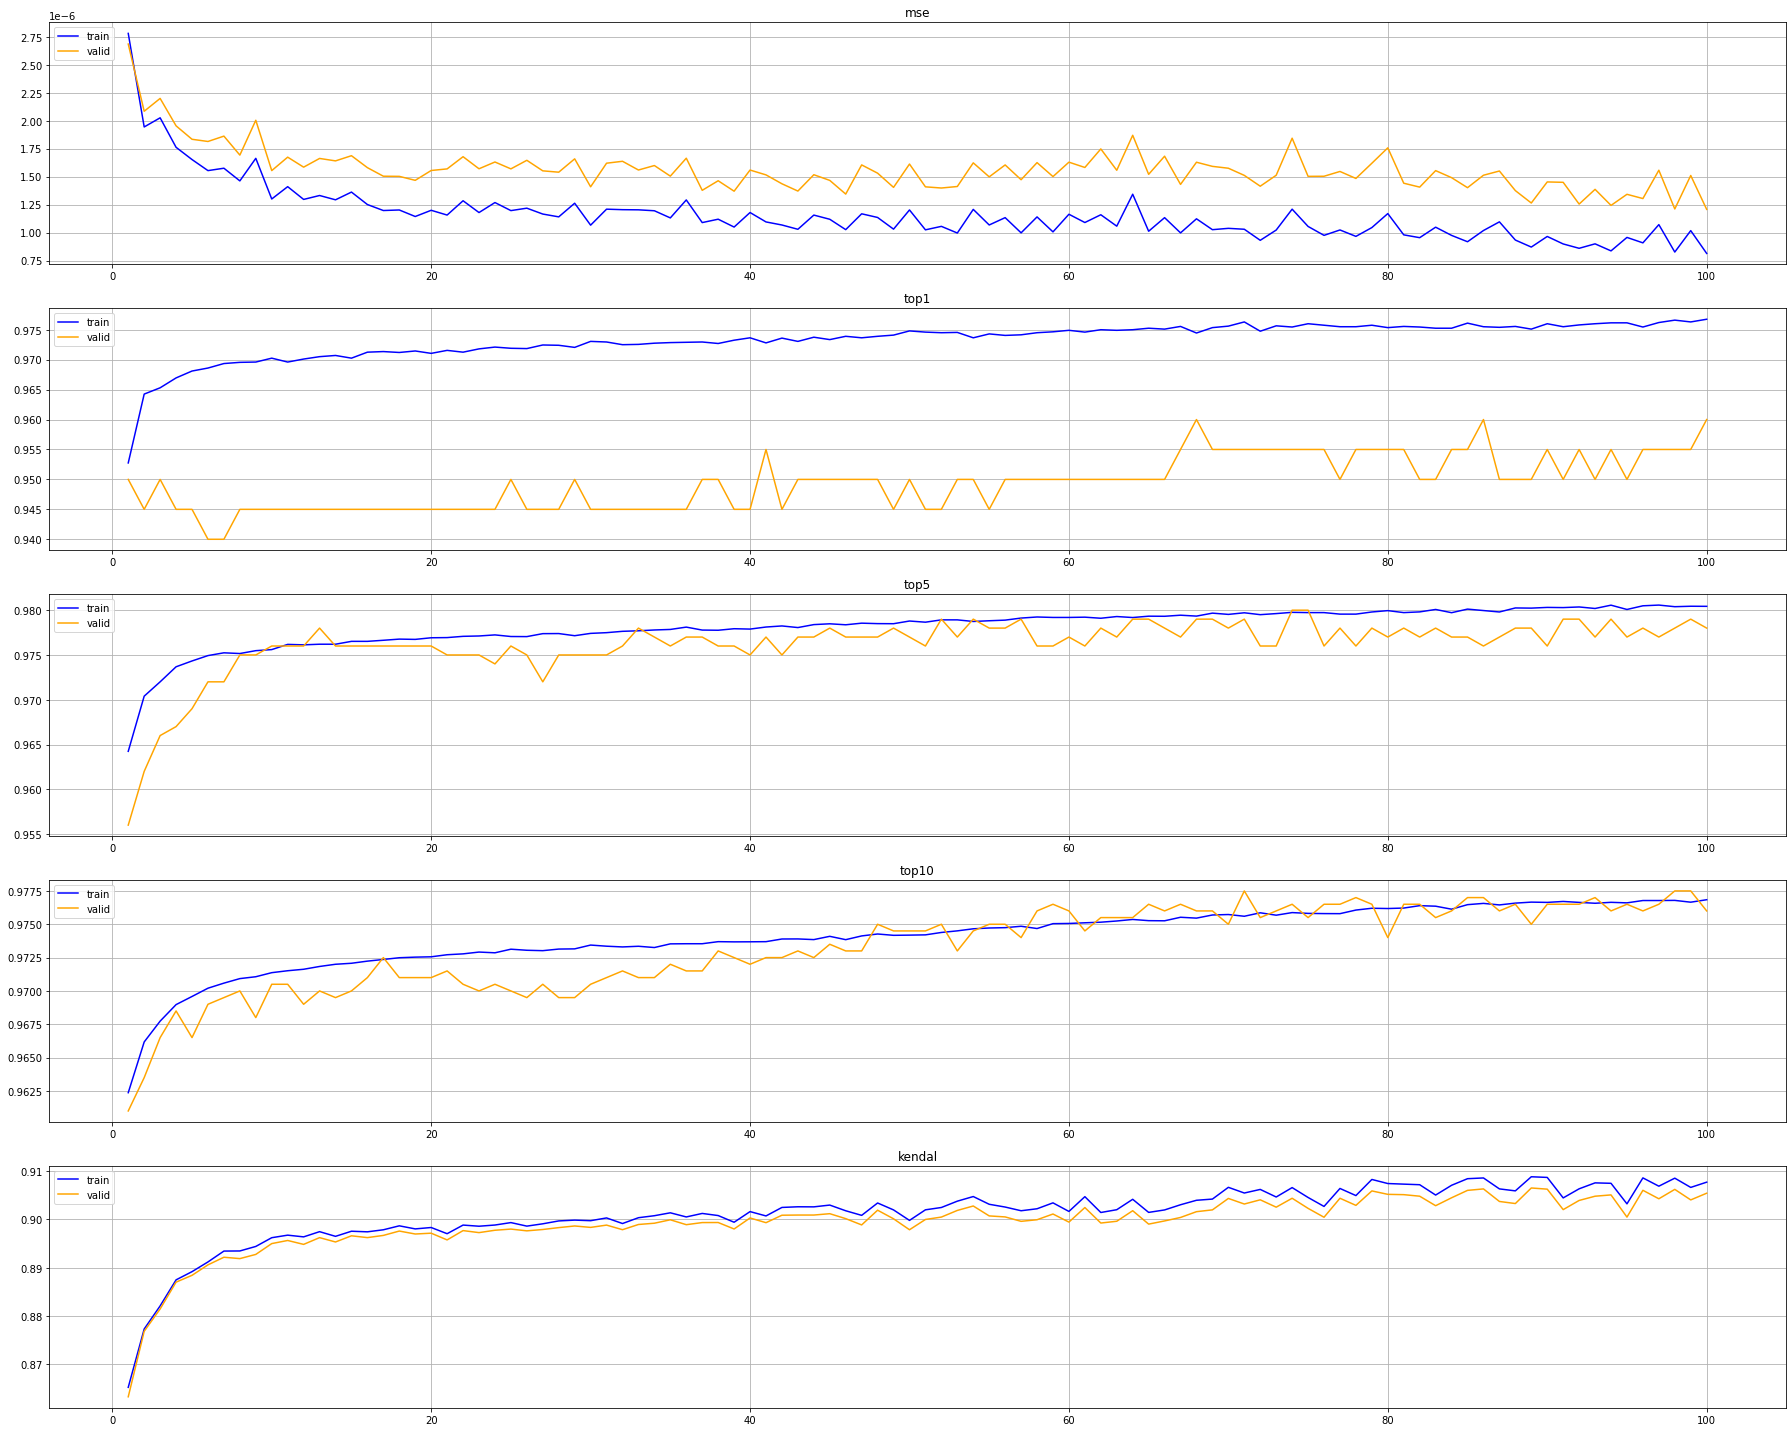

In [36]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    keys = list(train.keys())
    epochs = len(train[keys[0]])

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]

        ax.plot(x, train[key], color="blue")
        ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Compare diff scale

In [ ]:
weights = os.path.join(setting._root, "weights")

for weight_f in os.listdir(weights):
    print("weight: {}".format(weight_f))
    
    model, _ = load_checkpoint(
                    os.path.join(weights, weight_f),
                    "cpu",
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)
    model.eval()
    
    basename = os.path.splitext(weight_f)[0]
    with open(os.path.join(setting._root, "{}.json".format(basename)), "w") as f:
        jsn = {
            "top1": [],
            "top5": [],
            "top10": [],
            "kendal": [],
            "time": []
        }

        for edge_list, score in zip(synthetic, between):

            data = to_data(edge_list, score)

            start = time.time()
            bc_pr = model(data)
            end = time.time()

            bc_gt = np.array(data.y)


            jsn["time"].append(end-start)
            jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
            jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
            jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
            jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))

        json.dump(jsn, f)
    

In [ ]:
with open(os.path.join(setting._root, "result", "comparison", "200.json"), "r") as f_200, \
    open(os.path.join(setting._root, "result", "comparison", "300.json"), "r") as f_300, \
    open(os.path.join(setting._root, "result", "comparison", "1200.json"), "r") as f_1200, \
    open(os.path.join(setting._root, "result", "comparison", "3000.json"), "r") as f_3000, \
    open(os.path.join(setting._root, "result", "comparison", "5000.json"), "r") as f_5000 :
    
    r_200 = json.load(f_200)
    r_300 = json.load(f_300)
    r_1200 = json.load(f_1200)
    r_3000 = json.load(f_3000)
    r_5000 = json.load(f_5000)

    keys = list(r_200.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([r_200[key], r_300[key], r_1200[key], r_3000[key], r_5000[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        print("\n{}".format(key))
        ### Calculate mean and std
        r_200_ = np.array(r_200[key])
        print("scale=200, mean={}, std={}".format(np.mean(r_200_), np.std(r_200_)))
        
        r_300_ = np.array(r_300[key])
        print("scale=300, mean={}, std={}".format(np.mean(r_300_), np.std(r_300_)))
        
        r_1200_ = np.array(r_1200[key])
        print("scale=1200, mean={}, std={}".format(np.mean(r_1200_), np.std(r_1200_)))
        
        r_3000_ = np.array(r_3000[key])
        print("scale=3000, mean={}, std={}".format(np.mean(r_3000_), np.std(r_3000_)))
         
        r_5000_ = np.array(r_5000[key])
        print("scale=5000, mean={}, std={}".format(np.mean(r_5000_), np.std(r_5000_)))
        
    
    plt.setp(axs,  xticklabels=['200', '300', '1200', "3000", "5000"])
    plt.savefig(os.path.join(setting._root, "result", "comparison", "comp.png"), facecolor="white")
    
    